In [42]:
import zipfile
import os
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                               
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
COVID_path = "COVID-19_Radiography_Dataset\COVID\images"
lung_path = "COVID-19_Radiography_Dataset\Lung_Opacity\images"
normal_path = "COVID-19_Radiography_Dataset\\Normal\images"
viral_path = "COVID-19_Radiography_Dataset\Viral Pneumonia\images"

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\V'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18572\3712144418.py:1: SyntaxWarning: invalid escape sequence '\C'
  COVID_path = "COVID-19_Radiography_Dataset\COVID\images"
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18572\3712144418.py:2: SyntaxWarning: invalid escape sequence '\L'
  lung_path = "COVID-19_Radiography_Dataset\Lung_Opacity\images"
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18572\3712144418.py:3: SyntaxWarning: invalid escape sequence '\i'
  normal_path = "COVID-19_Radiography_Dataset\\Normal\images"
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18572\3712144418.py:4: SyntaxWarn

In [3]:
class_paths = {
    COVID_path: 0,
    lung_path: 1,
    normal_path: 2,
    viral_path: 3
}


IMAGE_SIZE = (150, 150)


In [4]:
def load_data():
    images = []
    labels = []

    print("Loading dataset...")

    # Iterate over each class path and its corresponding label
    for class_path, label in class_paths.items():
        if not os.path.exists(class_path):
            print(f"Warning: Directory {class_path} does not exist. Skipping.")
            continue

        # Iterate through each image file in the class folder
        for file in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, file)
            # Check if the path is a file and has a valid image extension
            if not os.path.isfile(img_path) or not file.lower().endswith(('.png', '.jpg', '.jpeg')):
                print("WTF")
                continue

            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Image {img_path} could not be loaded.")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            images.append(image)
            labels.append(label)

    # Convert lists to arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    return images, labels




In [5]:
# Load the data
images, labels = load_data()

class_names = ['COVID', 'Lung_Opacity', 'Viral pneumonia', 'Normal']
num_classes = len(class_names)
labels_categorical = to_categorical(labels, num_classes)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels_categorical, test_size=0.2, random_state=42
)


Loading dataset...


100%|██████████| 1345/1345 [00:03<00:00, 437.79it/s]


In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 16899
Number of testing examples: 4225
Each image is of size: (150, 150)


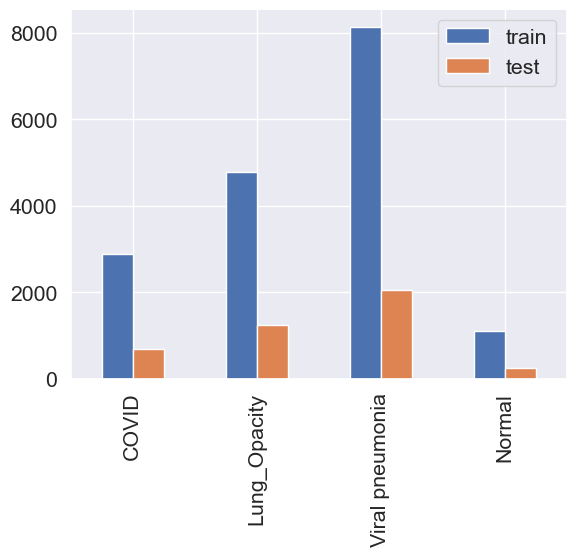

In [9]:
# Convert one-hot encoded labels back to integer class labels
train_labels_int = np.argmax(train_labels, axis=1)
test_labels_int = np.argmax(test_labels, axis=1)

# Get class distribution for training and test labels
_, train_counts = np.unique(train_labels_int, return_counts=True)
_, test_counts = np.unique(test_labels_int, return_counts=True)

# Plot the class distribution for training and testing sets
pd.DataFrame({'train': train_counts,
              'test': test_counts}, 
             index=class_names).plot.bar()
plt.show()


In [10]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [15]:
def display_random_image(class_names, images, labels):
    """
    Display a random image from the images array and its corresponding label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    
    # For one-hot encoded labels, use np.argmax to find the class index
    class_index = np.argmax(labels[index])
    
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.grid(False)  # Remove grid
    plt.title('Image #{} : {}'.format(index, class_names[class_index]))  # Display class name
    plt.show()


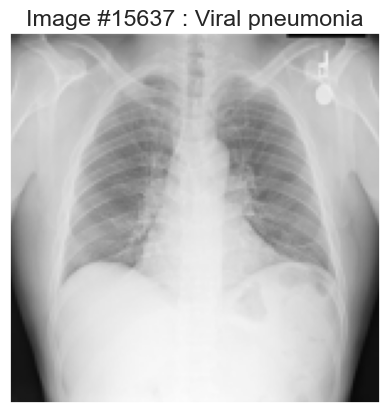

In [16]:
display_random_image(class_names, train_images, train_labels)

In [17]:
def display_examples(class_names, images, labels):
    """
    Display 25 images from the images array with their corresponding labels.
    """

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.grid(False)  # Remove grid
        
        plt.imshow(images[i], cmap=plt.cm.binary)
        
        # For one-hot encoded labels, use np.argmax to get the class index
        class_index = np.argmax(labels[i])
        
        plt.xlabel(class_names[class_index])  # Use the class name based on the class index
        
    plt.show()


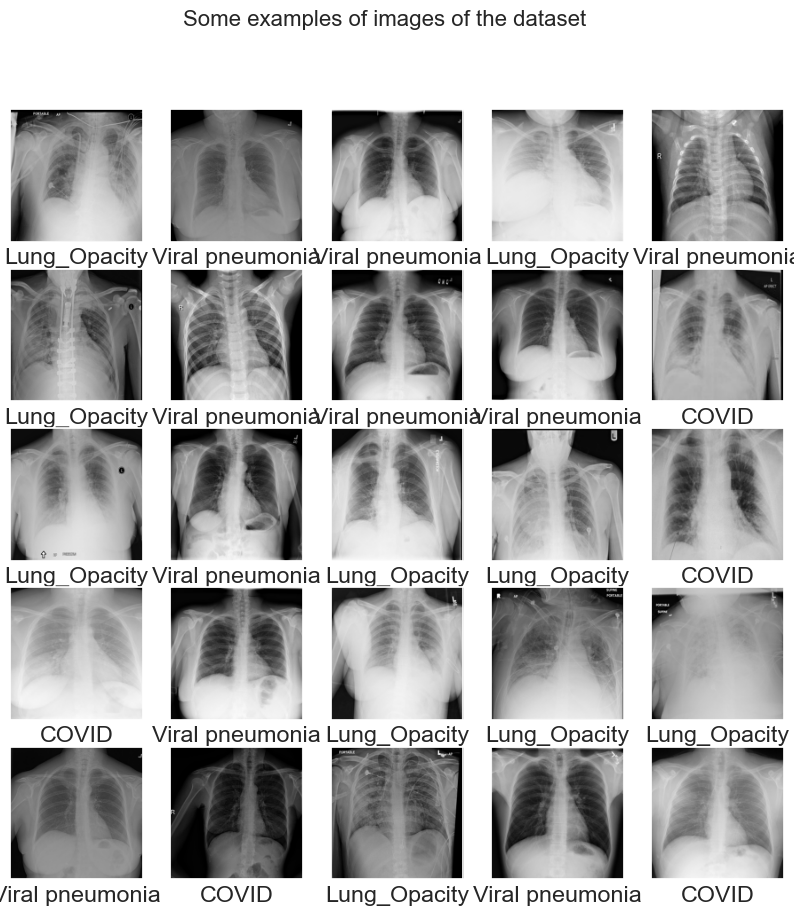

In [18]:
display_examples(class_names, train_images, train_labels)

In [19]:
# %% Create the model using MobileNetV2
def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [43]:
# %% Create the model
input_shape = (150, 150, 3)
model = create_mobilenet_model(input_shape, num_classes)

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training images
datagen.fit(train_images)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# %% Training with early stopping
batch_size = 32
epochs = 50

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18572\2779244248.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


In [44]:
# %% Train the model
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 131s 238ms/step - accuracy: 0.7117 - loss: 0.8195 - val_accuracy: 0.8490 - val_loss: 0.4226
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 112s 212ms/step - accuracy: 0.8487 - loss: 0.4070 - val_accuracy: 0.8663 - val_loss: 0.3708
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 114s 215ms/step - accuracy: 0.8693 - loss: 0.3555 - val_accuracy: 0.8651 - val_loss: 0.3604
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 111s 209ms/step - accuracy: 0.8774 - loss: 0.3322 - val_accuracy: 0.8701 - val_loss: 0.3576
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 119s 225ms/step - accuracy: 0.8806 - loss: 0.3226 - val_accuracy: 0.8722 - val_loss: 0.3438
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 121s 229ms/step - accuracy: 0.8845 - loss: 0.3069 - val_accuracy: 0.8651 - val_loss: 0.3539
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 115s 217ms/step - accuracy: 0.8904 - loss: 0.2934 - val_accuracy: 0.8682 - val_loss: 0.3465
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 118s 224ms/step - accuracy: 0.8936 -

In [45]:
# %% Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


Validation Loss: 0.3438359200954437
Validation Accuracy: 0.8721893429756165


In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# %% Plot accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [47]:
# %% Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

In [48]:
# %% Per-class accuracy
def calculate_class_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    class_accuracy_dict = dict(zip(class_names, per_class_accuracy))
    sorted_class_accuracy = dict(sorted(class_accuracy_dict.items(), key=lambda x: x[1], reverse=True))

    print("\nPer-Class Accuracy:")
    for class_name, acc in sorted_class_accuracy.items():
        print(f"{class_name}: {acc * 100:.2f}%")

In [50]:
# %% Evaluate on validation data
def evaluate_model(model, X_val, y_val, class_names):
    # Predict on validation data
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    # Plot accuracy and loss
    plot_training_history(history)

    # Plot confusion matrix
    plot_confusion_matrix(y_val_true, y_val_pred, class_names)

    # Calculate per-class accuracy
    calculate_class_accuracy(y_val_true, y_val_pred, class_names)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val_true, y_val_pred, target_names=class_names))

133/133 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step


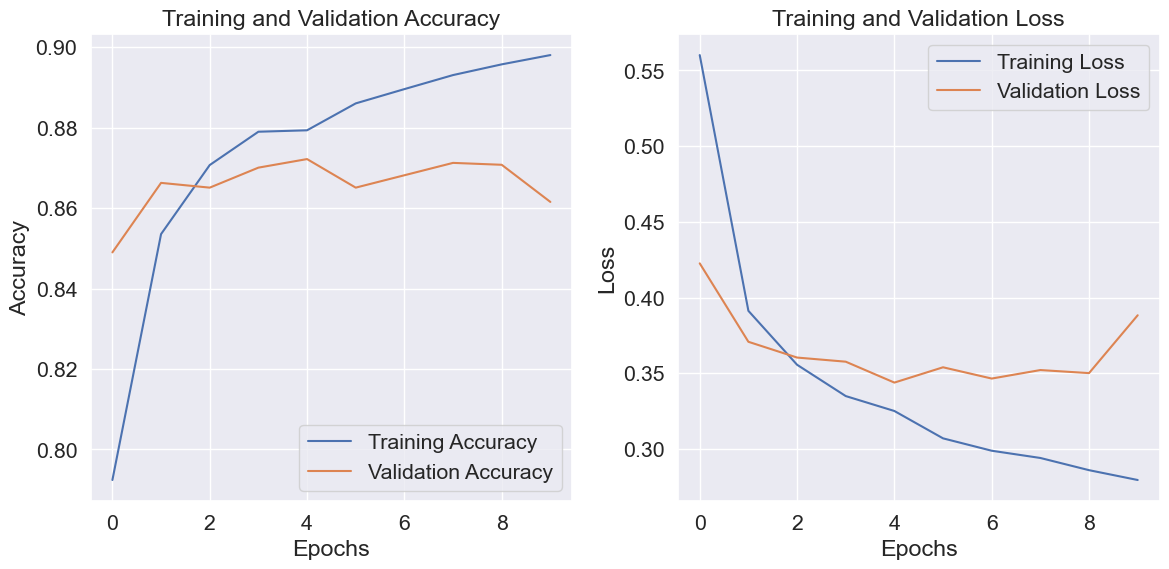

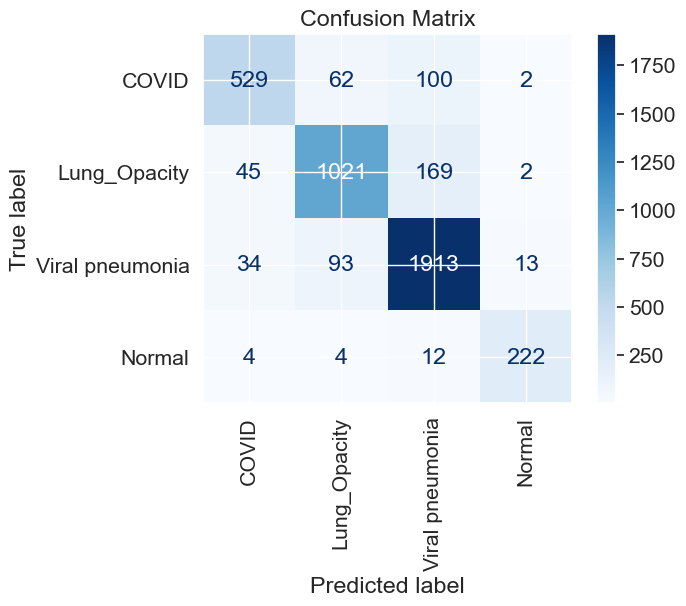


Per-Class Accuracy:
Viral pneumonia: 93.18%
Normal: 91.74%
Lung_Opacity: 82.54%
COVID: 76.33%

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.86      0.76      0.81       693
   Lung_Opacity       0.87      0.83      0.84      1237
Viral pneumonia       0.87      0.93      0.90      2053
         Normal       0.93      0.92      0.92       242

       accuracy                           0.87      4225
      macro avg       0.88      0.86      0.87      4225
   weighted avg       0.87      0.87      0.87      4225



In [51]:
evaluate_model(model, test_images, test_labels, class_names)